# Explore the Nav2D environment

In [ ]:
import mujoco as mj
import gymnasium as gym
import nav2d
import pyautogui

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}

# Reference for setting visual flags https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjtvisflag
visual_options = {2: True, 8: True}      # e.g., visualize the joints by setting mjVIS_JOINT (index 2) = True

# There are a few visualization things that cannot be set when making the env
# Ref - https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/mujoco/mujoco_rendering.py
# They can only be changed via keypresses in the gymnasium mujoco rendering. 
# Here are some flags to specify what key to press. The key presses are simulated using `pyautogui`
# (Super rough appproach but oh well)
DEFAULT_CAMERA = "overhead_camera"
ENABLE_FRAME = True                     # enable the body frames
RENDER_EVERY_FRAME = True              # similar sim speed as MuJoCo rendering when set to False, else slower

env = gym.make("Nav2D-v0", 
               render_mode="human", 
               width=width, height=height,
               default_camera_config=default_camera_config,
               visual_options=visual_options
               )
obs, info = env.reset()

# Simulate keypress for visualization elements in gymnasium MuJoCo rendering
if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
if ENABLE_FRAME: pyautogui.press('e') 
if not RENDER_EVERY_FRAME: pyautogui.press('d') 

for i in range(1):
    done = False
    # enable the body frame by simulating a keypress once lmao
    
    while not done:
        action = [1.0, 0, 1.0]
        nobs, rew, term, trunc, info = env.step(action)
        
        done = term or trunc
        obs = nobs if not done else env.reset()[0]
        # if done: print(nobs, info)

env.close()

# Custom TD3

## Library Import

In [1]:
# --- import the custom-made TD3 algorithm
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import nav2d        # Have to import the nav2d Python script, else we can't make env
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import json
import os, re
import sys
sys.path.insert(0,'..')
from algorithms import TD3

## Custom TD3 Training

In [7]:
model_registry = {
    'TD3_v0': {
        'actor_config': [256, 256],
        'critic_config': [256, 256]
    },
}

MODEL_NAME = 'TD3_v0'
ALPHA1 = 1e-3
ALPHA2 = 1e-3
BETA = 1e-3
GAMMA = 0.99
TAU_C = 5e-3
TAU_A = 5e-3
SIGMA = 0.2
CLIP = 0.5

BUFFER_SIZE = 20_000
BUFFER_INIT = 2_000
BATCH_SIZE = 1024
  
UPDATE_FREQ = 2
UPDATE_STEP = 2
TRAIN_ITER = 50_000
RAND_GOAL_FREQ = 5
TRAIN_CRIT = {"pass_limit": 3, "pass_score": 0, 'coeff_var_limit': 1.0}
RESULT_FOLDER = 'Nav2D_TD3_results'
CUDA_ENABLED = True
EARLY_STOP = True

run_00018:   2%|▋                                              | 768/50000 [00:03<03:36, 227.59it/s]/home/controlslab/ROS2_DRL_Navigation/.venv/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)
run_00018:  95%|███████████████████████████████████████████▉  | 47699/50000 [03:57<00:42, 54.14it/s]

Good training at episode  125 with reward of 1.312. Evaluation results μ=-406.515, σ= 2.162, CV= 0.005


run_00018: 100%|█████████████████████████████████████████████| 50000/50000 [04:09<00:00, 200.62it/s]


Training ended with no good model found :<
Best model episode 0


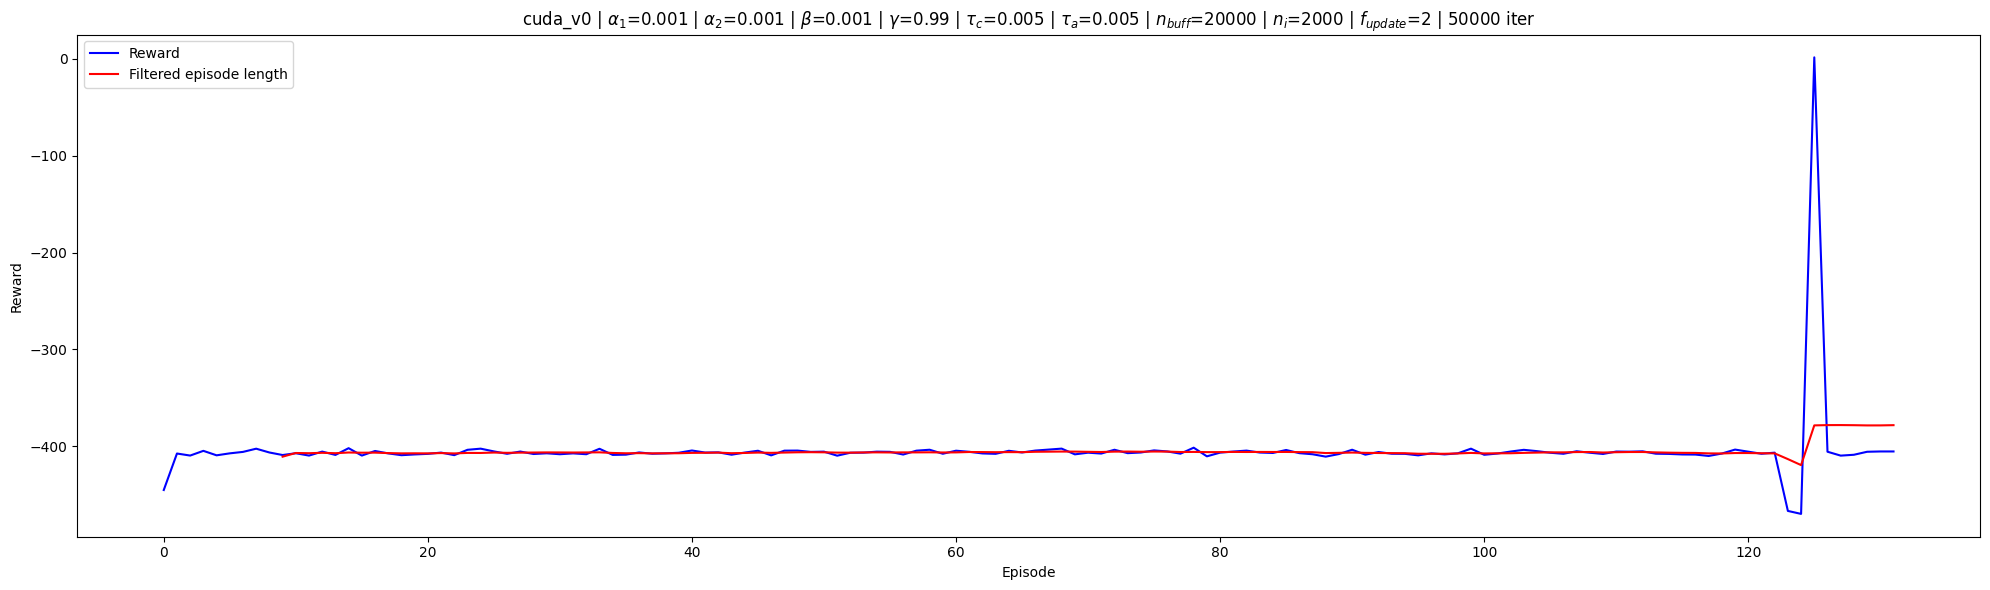

In [10]:
# env = TimeLimit(gym.make("Nav2D-v0", render_mode="human"), max_episode_steps = 1_000)

env = gym.make("Nav2D-v0", render_mode="rgb_array")
for i in range(1):    
    seed = np.random.randint(1,100)
    TD3_experiment = TD3(model_name = MODEL_NAME, model_registry=model_registry, env=env,
                     alpha1=ALPHA1,alpha2=ALPHA2,beta=BETA,gamma=GAMMA,
                     tau_c=TAU_C,tau_a=TAU_A,sigma=SIGMA,clip=CLIP,
                     buffer_size=BUFFER_SIZE,buffer_init=BUFFER_INIT, batch_size=BATCH_SIZE, 
                     update_f=UPDATE_FREQ, update_step=UPDATE_STEP, iter=TRAIN_ITER,
                    #  rand_goal_freq=RAND_GOAL_FREQ,
                     seed=seed,
                     train_crit=TRAIN_CRIT,
                     result_folder=RESULT_FOLDER,
                     cuda_enabled=CUDA_ENABLED)                 
    TD3_experiment.train(early_stop=EARLY_STOP,verbose=True)         

In [9]:
env.close()

## Load and Simulate models

In [ ]:
def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

def EMA_filter(reward: list, alpha: float=0.1):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output

def plot_fn(history, xlabel:str='step', ylabel: str='reward', alpha: float=0.0):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(history)
        episodes = range(n_episodes)
        filtered_reward_hist = EMA_filter(history, alpha)

        legend = []
        plt.figure(figsize=(20,6))
        plt.plot(episodes, history[:n_episodes], color = "blue"); legend.append(ylabel)
        if alpha:
            plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red"); legend.append('filtered '+ylabel)
        # plt.title(f'Total reward per episode - {self.hyperparam_config}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(legend)
        plt.grid(which='both')

        plt.tight_layout()
        # if self.save_path:
        #     plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

In [ ]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int,
                 act_dim: int,
                 act_low, act_high, 
                 hidden_layers=[64,64], 
                 cuda_enabled=False):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.act_low, self.act_high = act_low, act_high

        self.layers = nn.ModuleList()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        # hidden layers
        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(obs_dim, layer_size))
            obs_dim = layer_size
        # output layers
        self.layers.append(nn.Linear(obs_dim, self.act_dim))
        self.tanh = nn.Tanh()

        if cuda_enabled: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        act_tanh = self.tanh(output)

        # rescale to environment bounds
        act = 0.5 * (act_tanh + 1.0) * (self.act_high - self.act_low) + self.act_low
        return act

In [ ]:
## Manually select a folder/run to load
run_number = 'run_00016'

## Find the paths to the param_config and model checkpoint
# RESULT_DIR = os.path.dirname(REINFORCE_experiment.save_path)    # Can run this after running one experiment
BASE_DIR = os.getcwd()
RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

## Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_name = data['parameters']['model_name']
model_config = model_registry[model_name]['actor_config']

n_test_eps = 2

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}
render_mode = 'human' if n_test_eps <= 5 else 'rgb_array'

env_test = gym.make('Nav2D-v0',
               render_mode=render_mode,
               width=width,height=height,
               default_camera_config=default_camera_config
            )

obs_space = env_test.observation_space.shape[0]
act_space = env_test.action_space.shape[0]
act_low = torch.as_tensor(env_test.action_space.low, dtype=torch.float32, device = 'cpu')
act_high = torch.as_tensor(env_test.action_space.high, dtype=torch.float32, device = 'cpu')

# Create the model according to the model version in the model registry
policy_net= Actor(obs_space, act_space, 
                    act_low=act_low, act_high=act_high, 
                    hidden_layers=model_config)
load_model(policy_net, MODEL_PATH)

act_hist = []
rew_hist = []
eps_rew_hist = []
torso_z_hist = []

noise_std = 0
truncated = True

for eps in range(n_test_eps):
    obs, _ = env_test.reset()
    done = False
    torso_z_hist.append(obs[0])

    while not done:
        with torch.no_grad():
            obs_t = torch.as_tensor(obs, dtype = torch.float32, device = 'cpu')
            act = policy_net(obs_t)
            act += torch.randn_like(act) * noise_std

            nobs, rew, term, trunc, _ = env_test.step(act.numpy())

            act_hist.append(act.numpy())
            torso_z_hist.append(obs[0])

            # rew_hist.append(rew)
            if truncated:
                rew_hist.append(rew)
                truncated = False
            else:
                rew_hist.append(rew_hist[-1]+rew)

            done = term or trunc
            if not done:
                obs = nobs  
            else:
                obs = env_test.reset()[0]
                truncated = True
                eps_rew_hist.append(rew_hist[-1])
                msg = 'done due to termination' if term else 'done due to truncation'
    # print(f'episode {eps:3d} ' + msg)
env_test.close()

plot_fn(rew_hist, ylabel='instantaneous reward')

# Statistical analysis
if n_test_eps > 1:
    print(f"Evaluation of {run_number} after {n_test_eps} eval episodes | µ = {mean(eps_rew_hist):5.2f} | σ = {stdev(eps_rew_hist):5.2f}")

else:
    # --- plot the z-position of the torso
    plot_fn(torso_z_hist, ylabel='torso z level')

    # --- unpack the actions and plot
    act1_hist, act2_hist, act3_hist, act4_hist, act5_hist, act6_hist = zip(*act_hist)
    legends=[]
    plt.figure(figsize=(20,6))
    plt.plot(range(len(act1_hist)), act1_hist, color = "blue"); legends.append(r"right thigh $\tau_{0}$")
    plt.plot(range(len(act2_hist)), act2_hist, color = "orange"); legends.append(r"right leg $\tau_{1}$")
    plt.plot(range(len(act3_hist)), act3_hist, color = "green"); legends.append(r"right foot $\tau_{2}$")
    plt.title("Right leg torques vs time")
    plt.legend(legends, bbox_to_anchor=[0.5, -0.1], loc='center', ncol=10)
    plt.grid(which='both')
    plt.show()

    legends=[]
    plt.figure(figsize=(20,6))
    plt.plot(range(len(act4_hist)), act4_hist, color = "blue"); legends.append(r"left thigh $\tau_{3}$")
    plt.plot(range(len(act5_hist)), act5_hist, color = "orange"); legends.append(r"left leg $\tau_{l2}$")
    plt.plot(range(len(act6_hist)), act6_hist, color = "green"); legends.append(r"left foot $\tau_{l3}$")
    plt.title("Left leg torques vs time")
    plt.legend(legends, bbox_to_anchor=[0.5, -0.1], loc='center', ncol=10)
    plt.grid(which='both')
    plt.show()

# SB3 TD3

## SB3 Training

In [ ]:
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
import nav2d        # Have to import the nav2d Python script, else we can't make env
import os, re

In [ ]:
type(env)

In [ ]:
type(gym.make("Nav2D-v0", render_mode="rgb_array"))

In [ ]:
vec_env = make_vec_env("Nav2D-v0", n_envs=8, vec_env_cls=DummyVecEnv)
model = TD3("MlpPolicy", vec_env, 
            learning_rate=1e-3,         # lr for all networds - Q-values, Actor, Value function
            buffer_size=10_000,         # replay buffer size
            learning_starts=1_000,        # # of data collection step before training
            batch_size=512,
            tau=5e-3,                   # polyak update coefficient
            gamma=0.99,
            train_freq=1,
            gradient_steps=2, 
            action_noise=None, 
            n_steps=1,                  # n-step TD learning
            policy_delay=2,             # the policy and target networks are updated every policy_delay steps
            target_policy_noise=0.3,    # stdev of noise added to target policy
            target_noise_clip=0.5,      # limit of asbsolute value of noise
            verbose=2)
model.learn(total_timesteps=100_000)

## Save the Trained Model

In [ ]:
BASE_DIR = os.getcwd()
RESULT_FOLDER = 'Nav2D_TD3_SB3_results'
RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.exists(os.path.join(RESULT_DIR,d))]
run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
# model.save('reacher')

trial_number = max(run_numbers, default=-1) + 1
model.save(f'{RESULT_FOLDER}/run_{trial_number:05d}')

## Load and Simulate the Model

In [ ]:
import pyautogui

model_load = TD3.load('Nav2D_TD3_SB3_results/run_00006')

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90.0, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}
camera_id = 2

DEFAULT_CAMERA = "overhead_camera"
ENABLE_FRAME = True                     # enable the body frames
RENDER_EVERY_FRAME = True              # similar sim speed as MuJoCo rendering when set to False, else slower

test_env = gym.make("Nav2D-v0", render_mode='human', 
                    width=width,height=height,
                    default_camera_config=default_camera_config,
                    camera_id=camera_id,
                    # frame_skip=2,
                    # camera_name="camera",
                    # max_episode_steps=100
                    )
obs, info = test_env.reset()

if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
if ENABLE_FRAME: pyautogui.press('e') 
if not RENDER_EVERY_FRAME: pyautogui.press('d') 

for eps in range(5):
    obs, _ = test_env.reset()
    dones = False

    while not dones:
        action, _ = model_load.predict(obs, deterministic=True)
        nobs, rewards, dones, info, _ = test_env.step(action)
        obs = nobs if not dones else test_env.reset()
        # vec_env.render("human")

test_env.close()